In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.random_projection import SparseRandomProjection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
import gc
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.shape

(4459, 4993)

In [4]:
# test_ID = test['ID']
label = train['target']

In [5]:
label = np.log1p(label)

In [6]:
label.shape

(4459,)

In [7]:
train.drop("ID",axis=1,inplace=True)
train.drop("target",axis=1,inplace=True)

In [8]:
cols_with_onlyone_val = train.columns[train.nunique() == 1]

In [9]:
train.drop(cols_with_onlyone_val.values,axis=1,inplace=True)
test.drop(cols_with_onlyone_val.values,axis=1,inplace=True)

In [11]:
num_of_decimals = 32

In [12]:
train = train.round(num_of_decimals)
test = test.round(num_of_decimals)

In [13]:
label.shape

(4459,)

In [14]:
# cols_to_Remove = []
# columns = train.columns
# for i in range(len(columns)-1):
#     v = train[columns[i]].values
#     for j in range(i+1,len(columns)):
#         if np.array_equal(v,train[columns[j]].values):
#             cols_to_Remove.append(columns[j])

In [15]:
# train.drop(cols_to_Remove,axis=1,inplace=True)
# test.drop(cols_to_Remove,axis=1,inplace=True)

In [16]:
train = train.loc[:,~train.columns.duplicated()]
test = test.loc[:,~test.columns.duplicated()]

In [18]:
train.shape

(4459, 4735)

In [19]:
def rmsle(y,pred):
    return np.sqrt(np.mean(np.power(y-pred,2)))


In [20]:
X_train,X_test,y_train,y_test = train_test_split(train,label.values,test_size=0.2,random_state=1)

In [21]:
model = RandomForestRegressor(n_jobs=-1,random_state=1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [22]:
rmsle(y_test,model.predict(X_test))

1.4834496478627184

In [23]:
important_cols = pd.DataFrame({"Importance":model.feature_importances_,"Feature":train.columns}).sort_values(by=["Importance"],ascending=False)[:1000]['Feature'].values


In [26]:
train = train[important_cols]
test = test[important_cols]

In [27]:
ntrain = len(train)
ntest = len(test)
tmp = pd.concat([train,test])
train_tmp = train[train!=0]
test_tmp = test[test!=0]


In [28]:
train['count_notzero'] = (train != 0).sum(axis=1)
test['count_notzero'] = (test != 0).sum(axis=1)
train['sum'] = train.sum(axis=1)
test['sum'] = test.sum(axis=1)
train['var'] = train_tmp.var(axis=1)
test['var'] = test_tmp.var(axis=1)
train["median"] = train_tmp.median(axis=1)
test["median"] = test_tmp.median(axis=1)
train["mean"] = train_tmp.mean(axis=1)
test["mean"] = test_tmp.mean(axis=1)
train["std"] = train_tmp.std(axis=1)
test["std"] = test_tmp.std(axis=1)
train["max"] = train_tmp.max(axis=1)
test["max"] = test_tmp.max(axis=1)
train["min"] = train_tmp.min(axis=1)
test["min"] = test_tmp.min(axis=1)
train["skew"] = train_tmp.skew(axis=1)
test["skew"] = test_tmp.skew(axis=1)
train["kurtosis"] = train_tmp.kurtosis(axis=1)
test["kurtosis"] = test_tmp.kurtosis(axis=1)

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:564: RuntimeWarning: divide by zero encountered in true_divide
  mean = values.sum(axis, dtype=np.float64) / count
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:622: RuntimeWarning: divide by zero encountered in true_divide
  mean = values.sum(axis, dtype=np.float64) / count


In [29]:
del(train_tmp)
del(test_tmp)

In [30]:
gc.collect()

133

In [31]:
test.to_csv("test_featured.csv",index=False)

In [32]:
del test
gc.collect()

0

In [33]:
def rmsle_cv(model,traindata):
    kf = KFold(n_splits=5,random_state=1).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model,traindata,label,scoring="neg_mean_squared_error",cv=kf))
    return rmse

In [34]:
class AveragingModel(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions,axis=1)
    

In [35]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.055, colsample_bylevel =0.5, 
                             gamma=1.5, learning_rate=0.02, max_depth=32, 
                             objective='reg:linear',booster='gbtree',
                             min_child_weight=57, n_estimators=1000, reg_alpha=0, 
                             reg_lambda = 0,eval_metric = 'rmse', subsample=0.7, 
                             silent=1, n_jobs = -1, early_stopping_rounds = 14,
                             random_state =0, nthread = -1)

model_lightgbm = lgb.LGBMRegressor(objective='regression',num_leaves=144,
                              learning_rate=0.005, n_estimators=720, max_depth=13,
                              metric='rmse',is_training_metric=True,
                              max_bin = 55, bagging_fraction = 0.8,verbose=-1,
                              bagging_freq = 5, feature_fraction = 0.9)

model_cat = cat.CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 0,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [37]:
train.fillna(value=0,inplace=True)

In [38]:
scaler = MinMaxScaler(feature_range=[0,1])
train_rescaled = scaler.fit_transform(train)

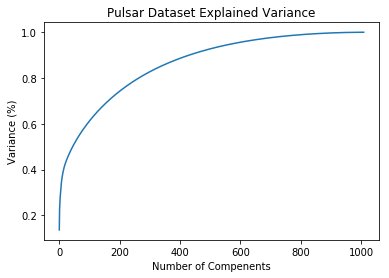

In [39]:
pca = PCA().fit(train_rescaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Compenents")
plt.ylabel("Variance (%)")
plt.title("Pulsar Dataset Explained Variance")
plt.show()
## 600 components seem to be resonable 

## Linear Regression

In [40]:
pca = PCA(n_components=600)
newTrain = pca.fit_transform(train_rescaled)

In [42]:
regr = LinearRegression()
np.mean(rmsle_cv(regr,newTrain))

1.8538090218333658

In [49]:
np.mean(rmsle_cv(regr,newTrain200))

1.6260309623921512

In [50]:
np.mean(rmsle_cv(regr,newTrain400))

1.757042561790917

In [53]:
np.mean(rmsle_cv(regr,newTrain800))

2.031468777260429

## Boosting

### 200Variables after pca

In [43]:
pca = PCA(n_components=200)
newTrain200 = pca.fit_transform(train_rescaled)

In [44]:
score = rmsle_cv(model_xgb,newTrain200)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lightgbm,newTrain200)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_cat,newTrain200)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))


Xgboost score: 1.4486 (0.0514)

LGBM score: 1.4217 (0.0473)

0:	learn: 13.8947832	total: 705ms	remaining: 5m 51s
50:	learn: 2.1836098	total: 32.5s	remaining: 4m 46s
100:	learn: 1.5377480	total: 58.2s	remaining: 3m 49s
150:	learn: 1.4767859	total: 1m 15s	remaining: 2m 55s
200:	learn: 1.4750314	total: 1m 17s	remaining: 1m 55s
250:	learn: 1.4750285	total: 1m 18s	remaining: 1m 17s
300:	learn: 1.4750284	total: 1m 19s	remaining: 52.4s
350:	learn: 1.4750284	total: 1m 20s	remaining: 34s
400:	learn: 1.4702513	total: 1m 21s	remaining: 20s
450:	learn: 1.4642473	total: 1m 22s	remaining: 8.97s
499:	learn: 1.4615073	total: 1m 23s	remaining: 0us
0:	learn: 13.9306636	total: 878ms	remaining: 7m 18s
50:	learn: 2.1768339	total: 34.3s	remaining: 5m 2s
100:	learn: 1.5109765	total: 1m 1s	remaining: 4m 2s
150:	learn: 1.4520939	total: 1m 19s	remaining: 3m 4s
200:	learn: 1.4497778	total: 1m 21s	remaining: 2m
250:	learn: 1.4497756	total: 1m 21s	remaining: 1m 21s
300:	learn: 1.4497756	total: 1m 22s	remaining: 54

In [45]:
pca = PCA(n_components=400)
newTrain400 = pca.fit_transform(train_rescaled)

In [46]:
score = rmsle_cv(model_xgb,newTrain400)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lightgbm,newTrain400)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_cat,newTrain400)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

Xgboost score: 1.4503 (0.0550)

LGBM score: 1.4225 (0.0469)

0:	learn: 13.9018976	total: 1.49s	remaining: 12m 22s
50:	learn: 2.2021544	total: 1m 8s	remaining: 10m
100:	learn: 1.5701159	total: 2m 12s	remaining: 8m 42s
150:	learn: 1.5070643	total: 3m 9s	remaining: 7m 19s
200:	learn: 1.5040190	total: 3m 12s	remaining: 4m 47s
250:	learn: 1.4913280	total: 3m 16s	remaining: 3m 14s
300:	learn: 1.4821848	total: 3m 19s	remaining: 2m 11s
350:	learn: 1.4763604	total: 3m 23s	remaining: 1m 26s
400:	learn: 1.4673984	total: 3m 30s	remaining: 51.9s
450:	learn: 1.4622724	total: 3m 34s	remaining: 23.3s
499:	learn: 1.4570209	total: 3m 40s	remaining: 0us
0:	learn: 13.9377011	total: 1.38s	remaining: 11m 30s
50:	learn: 2.1977237	total: 1m 3s	remaining: 9m 18s
100:	learn: 1.5523871	total: 2m	remaining: 7m 57s
150:	learn: 1.4873745	total: 2m 58s	remaining: 6m 51s
200:	learn: 1.4842612	total: 3m	remaining: 4m 29s
250:	learn: 1.4842542	total: 3m 1s	remaining: 3m
300:	learn: 1.4842542	total: 3m 2s	remaining: 2m


In [47]:
pca = PCA(n_components=600)
newTrain600 = pca.fit_transform(train_rescaled)

In [48]:
score = rmsle_cv(model_xgb,newTrain600)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lightgbm,newTrain600)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_cat,newTrain600)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

Xgboost score: 1.4544 (0.0562)

LGBM score: 1.4245 (0.0464)

0:	learn: 13.9303673	total: 2.14s	remaining: 17m 49s
50:	learn: 2.1704761	total: 1m 39s	remaining: 14m 33s
100:	learn: 1.5674080	total: 3m 11s	remaining: 12m 36s
150:	learn: 1.5154151	total: 4m 29s	remaining: 10m 22s
200:	learn: 1.5124096	total: 4m 36s	remaining: 6m 51s
250:	learn: 1.4946950	total: 4m 44s	remaining: 4m 41s
300:	learn: 1.4776281	total: 4m 51s	remaining: 3m 13s
350:	learn: 1.4733333	total: 5m 2s	remaining: 2m 8s
400:	learn: 1.4611556	total: 5m 20s	remaining: 1m 19s
450:	learn: 1.4529503	total: 5m 31s	remaining: 36s
499:	learn: 1.4458828	total: 5m 40s	remaining: 0us
0:	learn: 13.9673704	total: 2.26s	remaining: 18m 46s
50:	learn: 2.1649353	total: 1m 33s	remaining: 13m 41s
100:	learn: 1.5631744	total: 3m 2s	remaining: 12m 2s
150:	learn: 1.5051344	total: 4m 33s	remaining: 10m 32s
200:	learn: 1.5013718	total: 4m 42s	remaining: 7m
250:	learn: 1.5013635	total: 4m 43s	remaining: 4m 41s
300:	learn: 1.5013635	total: 4m 4

In [51]:
pca = PCA(n_components=800)
newTrain800 = pca.fit_transform(train_rescaled)

In [52]:
score = rmsle_cv(model_xgb,newTrain800)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lightgbm,newTrain800)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_cat,newTrain800)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

Xgboost score: 1.4616 (0.0608)

LGBM score: 1.4306 (0.0421)

0:	learn: 13.9093161	total: 3.16s	remaining: 26m 15s
50:	learn: 2.1545678	total: 2m 17s	remaining: 20m 7s
100:	learn: 1.5631989	total: 4m 21s	remaining: 17m 13s
150:	learn: 1.5056786	total: 6m 16s	remaining: 14m 31s
200:	learn: 1.5005751	total: 6m 42s	remaining: 9m 58s
250:	learn: 1.4820739	total: 6m 58s	remaining: 6m 55s
300:	learn: 1.4672024	total: 7m 25s	remaining: 4m 54s
350:	learn: 1.4520370	total: 7m 52s	remaining: 3m 20s
400:	learn: 1.4386571	total: 8m 9s	remaining: 2m
450:	learn: 1.4261076	total: 8m 25s	remaining: 54.9s
499:	learn: 1.4179118	total: 8m 34s	remaining: 0us
0:	learn: 13.9584928	total: 2.99s	remaining: 24m 50s
50:	learn: 2.1514571	total: 2m 18s	remaining: 20m 23s
100:	learn: 1.5462903	total: 4m 29s	remaining: 17m 42s
150:	learn: 1.4907854	total: 6m 32s	remaining: 15m 6s
200:	learn: 1.4876062	total: 6m 44s	remaining: 10m 1s
250:	learn: 1.4876050	total: 6m 45s	remaining: 6m 42s
300:	learn: 1.4876050	total: 6

In [55]:
score = rmsle_cv(model_xgb,train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lightgbm,train)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 1.3614 (0.0547)

LGBM score: 1.3420 (0.0468)



In [ ]:
averaged_model = AveragingModel(models = (model_xgb, model_lightgbm, model_cat))
score = rmsle_cv(averaged_model)
print("averaged score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))